### imports

In [9]:
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

import env
from utils import KaggleCameraDataset, progress_iter

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### useful routines

In [10]:
def jpg_quality(filepath):
    bash_cmd = "identify -verbose {0} | grep Quality".format(filepath)
    process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    output = filter(lambda s: 'Quality' in s, output.split('\n'))
    if not output: 
        return None
    return int(filter(lambda c: c.isdigit(), output[0]))

In [48]:
list(enumerate(KaggleCameraDataset.target_labels()))

[(0, 'HTC-1-M7'),
 (1, 'LG-Nexus-5x'),
 (2, 'Motorola-Droid-Maxx'),
 (3, 'Motorola-Nexus-6'),
 (4, 'Motorola-X'),
 (5, 'Samsung-Galaxy-Note3'),
 (6, 'Samsung-Galaxy-S4'),
 (7, 'Sony-NEX-7'),
 (8, 'iPhone-4s'),
 (9, 'iPhone-6')]

In [12]:
KaggleCameraDataset.is_rotation_allowed()

[True, True, True, True, True, False, False, False, False, False]

In [13]:
def resolutions(): # with all possible rotations
    return [
        [(1520, 2688), (2688, 1520)],
        [(3024, 4032), (4032, 3024)],
        [(2432, 4320), (4320, 2432)],
        [(1040, 780), (3088, 4130), (4130, 3088), (3120, 4160), (4160, 3120)],
        [(3120, 4160), (4160, 3120)],
        [(4128, 2322)],
        [(4128, 2322)],
        [(6000, 4000)],
        [(3264, 2448)],
        [(3264, 2448)],
    ]

In [14]:
(3120, 4160) in resolutions()[3]

True

In [15]:
(4000, 6000) in resolutions()[7]

False

## load all the data

In [16]:
train_data = KaggleCameraDataset('../data/', train=True)
glebs_train_data = KaggleCameraDataset('../data/glebs-train/', train=True)
glebs_val_data = KaggleCameraDataset('../data/glebs-val/', train=True)
alex_firsov_data = KaggleCameraDataset('../data/alex-firsov/', train=True)
esato_data = KaggleCameraDataset('../data/esato-com/', train=True)

## check quality of original training data

In [44]:
train_d = dict.fromkeys(train_data.X)

In [ ]:
for k in progress_iter(sorted(train_d), True):
    train_d[k] = jpg_quality(k)

In [46]:
train_stats = []
for x, y in progress_iter(zip(train_data.X, train_data.y), True):
    train_stats.append((x, y, jpg_quality(x)))

A Jupyter Widget

In [47]:
with open('../data/orig_stats.json', 'w') as f:
    json.dump(train_stats, f, indent=4, sort_keys=True)

In [14]:
min(filter(bool, train_d.values()))

92

(array([  1.00000000e+00,   1.00000000e+01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.64900000e+03,
          8.33000000e+02,   0.00000000e+00,   0.00000000e+00,
          2.57000000e+02]),
 array([ 92. ,  92.6,  93.2,  93.8,  94.4,  95. ,  95.6,  96.2,  96.8,
         97.4,  98. ]),
 <a list of 10 Patch objects>)

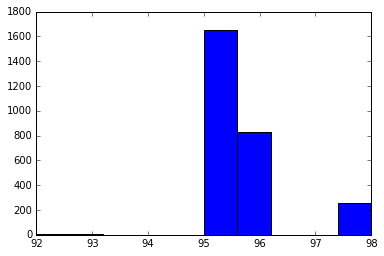

In [15]:
plt.hist(filter(bool, train_d.values()))

## collect stats about rest of the data
### 1) discard broken images, 2) check resolution, and store JPG quality

In [17]:
def make_stats(dataset):
    x_fpaths = dataset.X
    stats = {}
    for i in progress_iter(range(len(dataset)), verbose=True):
        try:
            x, y = dataset[i]
            x = np.asarray(x, dtype=np.uint8)
            if len(x.shape) != 3 or x.shape[0] < 1024 or x.shape[1] < 1024:
                continue
            d = {}
            d['x_fpath'] = x_fpaths[i]
            d['y'] = y
            d['res'] = (x.shape[0], x.shape[1])
            d['res_valid'] = d['res'] in resolutions()[y]
            d['quality'] = jpg_quality(x_fpaths[i])
            stats[i] = d
        except:
            pass
    return stats

### alex firsov's

In [18]:
alex_firsov_stats = make_stats(alex_firsov_data)

A Jupyter Widget

In [19]:
with open('../data/alex_firsov_stats.json', 'w') as f:
    json.dump(alex_firsov_stats, f, indent=4, sort_keys=True)

In [20]:
min(map(lambda d: d['quality'], alex_firsov_stats.values()))

85

(array([   3.,    0.,    0.,    2.,    0.,    3.,    3.,  332.,    0.,    1.]),
 array([ 85. ,  86.4,  87.8,  89.2,  90.6,  92. ,  93.4,  94.8,  96.2,
         97.6,  99. ]),
 <a list of 10 Patch objects>)

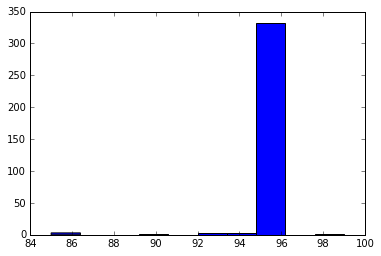

In [21]:
plt.hist(map(lambda d: d['quality'], alex_firsov_stats.values()))

In [22]:
sum(map(lambda d: d['res_valid'], alex_firsov_stats.values()))

1

### gleb's train

In [23]:
glebs_train_stats = make_stats(glebs_train_data)

A Jupyter Widget

/usr/local/lib/python2.7/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 7. 
  warnings.warn(str(msg))


In [24]:
for i in sorted(glebs_train_stats):
    if glebs_train_stats[i]['x_fpath'] == '../data/glebs-train/train/Samsung-Galaxy-S4/24750425488_00b9cac713_o.jpg':
        print i, glebs_train_stats[i]

1691 {'y': 6, 'x_fpath': '../data/glebs-train/train/Samsung-Galaxy-S4/24750425488_00b9cac713_o.jpg', 'res_valid': False, 'quality': 85, 'res': (2322, 4128)}


In [25]:
len(glebs_train_stats)

11004

In [26]:
with open('../data/glebs_train_stats.json', 'w') as f:
    json.dump(glebs_train_stats, f, indent=4, sort_keys=True)

In [38]:
min(map(lambda d: d['quality'], glebs_train_stats.values()))  # !!

45

In [28]:
sum(map(lambda d: d['res_valid'], glebs_train_stats.values()))  # ~25%

2664

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   4.00000000e+00,   7.00000000e+00,
          1.75000000e+02,   5.52000000e+02,   1.71600000e+03,
          8.54900000e+03]),
 array([  45. ,   50.5,   56. ,   61.5,   67. ,   72.5,   78. ,   83.5,
          89. ,   94.5,  100. ]),
 <a list of 10 Patch objects>)

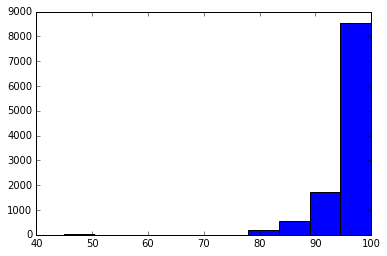

In [29]:
plt.hist(filter(bool, map(lambda d: d['quality'], glebs_train_stats.values())))

### gleb's val

In [30]:
glebs_val_stats = make_stats(glebs_val_data)

A Jupyter Widget

In [31]:
with open('../data/glebs_val_stats.json', 'w') as f:
    json.dump(glebs_val_stats, f, indent=4, sort_keys=True)

In [32]:
min(filter(bool, map(lambda d: d['quality'], glebs_val_stats.values()))), len(filter(bool, map(lambda d: d['quality'], glebs_val_stats.values())))

(92, 333)

In [33]:
sum(map(lambda d: d['res_valid'], glebs_val_stats.values()))

133

(array([   6.,    2.,    0.,  190.,    0.,   69.,    0.,    9.,   56.,    1.]),
 array([  92. ,   92.8,   93.6,   94.4,   95.2,   96. ,   96.8,   97.6,
          98.4,   99.2,  100. ]),
 <a list of 10 Patch objects>)

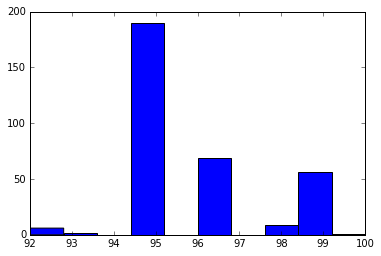

In [34]:
plt.hist(filter(bool, map(lambda d: d['quality'], glebs_val_stats.values())))

### esato

In [35]:
esato_stats = make_stats(esato_data)

A Jupyter Widget

/usr/local/lib/python2.7/dist-packages/PIL/TiffImagePlugin.py:569: UserWarning: Metadata Warning, tag 256 had too many entries: 2, expected 1
  tag, len(values)))
/usr/local/lib/python2.7/dist-packages/PIL/TiffImagePlugin.py:569: UserWarning: Metadata Warning, tag 257 had too many entries: 2, expected 1
  tag, len(values)))


In [36]:
with open('../data/esato_stats.json', 'w') as f:
    json.dump(esato_stats, f, indent=4, sort_keys=True)

In [37]:
len(esato_stats)

1519

In [40]:
min(map(lambda d: d['quality'], esato_stats.values()))

80

In [41]:
sum(map(lambda d: d['res_valid'], esato_stats.values()))

175

(array([  1.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   8.00000000e+00,   4.30000000e+01,
          5.40000000e+01,   4.60000000e+01,   1.03100000e+03,
          3.33000000e+02]),
 array([  80.,   82.,   84.,   86.,   88.,   90.,   92.,   94.,   96.,
          98.,  100.]),
 <a list of 10 Patch objects>)

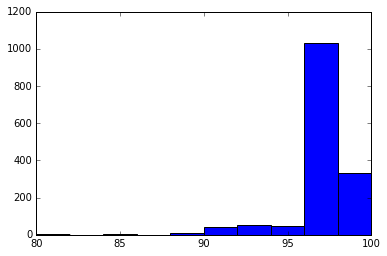

In [42]:
plt.hist(filter(bool, map(lambda d: d['quality'], esato_stats.values())))